In [2]:
# feature extractoring and preprocessing data
import librosa
import librosa.display
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from PIL import Image
from pathlib import Path
import csv
# Preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from scipy import signal
import scipy
#Reports
from sklearn.metrics import classification_report, confusion_matrix

import warnings
warnings.filterwarnings('ignore')

Text(0.5, 1.0, 'Energy')

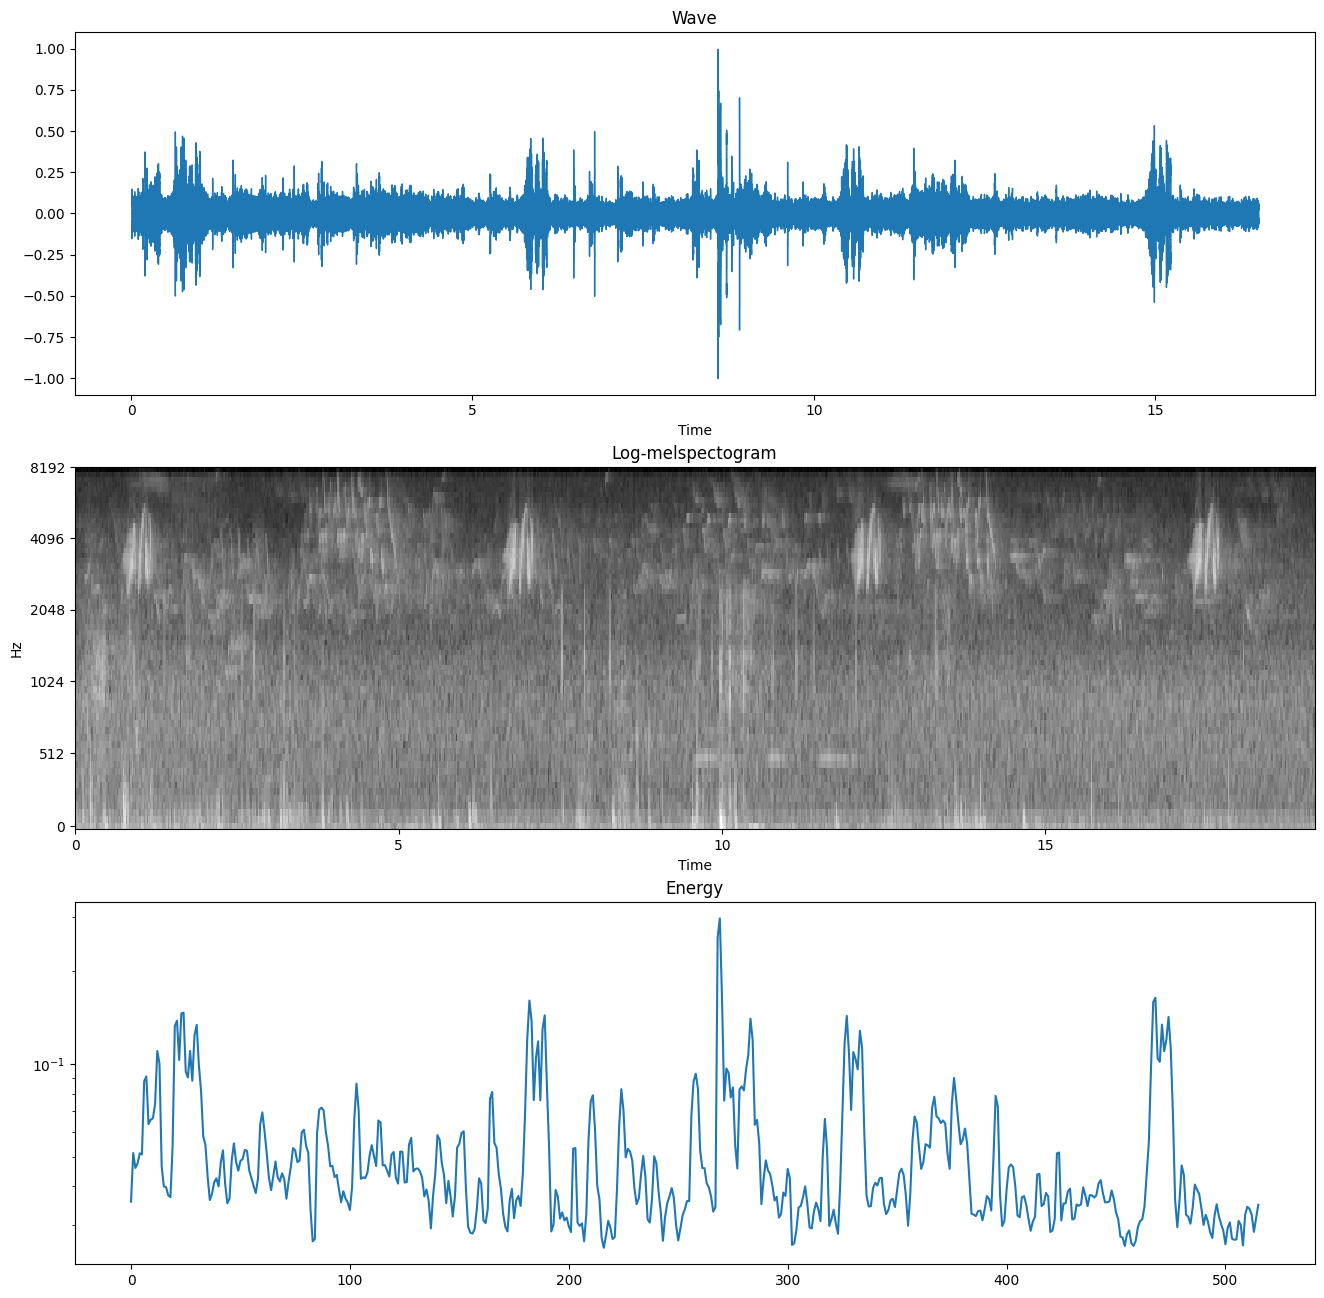

In [3]:
sr=16000
n_mels = 64
cmap = plt.get_cmap('gray')

e_file = '/media/sasanka/Expansion/xeno-canto-bird-recordings-extended-a-m/A-M/aldfly/XC16964.mp3'#XC16964.mp3

y, sr = librosa.load(e_file, mono=True, sr=sr)#duration=5
y = librosa.util.normalize(y, axis=0)
D = np.abs(librosa.stft(y, n_fft=int(0.040*sr),
                                hop_length=int(0.020*sr),
                                window='hann'))**2
S = librosa.feature.melspectrogram(S=D,sr=sr, n_mels=64)
plt.figure(figsize=(16,16))
sub = plt.subplot(3,1,1)
librosa.display.waveshow(y,sr=sr, x_axis='time')
sub.set_title('Wave')
sub2 = plt.subplot(3,1,2)
librosa.display.specshow(librosa.power_to_db(S,ref=np.max),
                                 y_axis='mel', fmax=8000,
                                 x_axis='time',
                                 cmap = cmap)
sub2.set_title('Log-melspectogram')
sub3 = plt.subplot(3,1,3)
rms = librosa.feature.rms(y=y,frame_length=1024, hop_length=512)
plt.semilogy(rms.T)
sub3.set_title('Energy')

In [4]:
import time
from datetime import timedelta as td


def _stft(y, n_fft, hop_length, win_length):
    return librosa.stft(y=y, n_fft=n_fft, hop_length=hop_length, win_length=win_length)


def _istft(y, hop_length, win_length):
    return librosa.istft(y, hop_length, win_length)


def _amp_to_db(x):
    return librosa.core.amplitude_to_db(x, ref=1.0, amin=1e-20, top_db=80.0)


def _db_to_amp(x,):
    return librosa.core.db_to_amplitude(x, ref=1.0)


def plot_spectrogram(signal, title):
    fig, ax = plt.subplots(figsize=(20, 4))
    cax = ax.matshow(
        signal,
        origin="lower",
        aspect="auto",
        cmap=plt.cm.seismic,
        vmin=-1 * np.max(np.abs(signal)),
        vmax=np.max(np.abs(signal)),
    )
    fig.colorbar(cax)
    ax.set_title(title)
    plt.tight_layout()
    plt.show()


def plot_statistics_and_filter(
    mean_freq_noise, std_freq_noise, noise_thresh, smoothing_filter
):
    fig, ax = plt.subplots(ncols=2, figsize=(20, 4))
    plt_mean, = ax[0].plot(mean_freq_noise, label="Mean power of noise")
    plt_std, = ax[0].plot(std_freq_noise, label="Std. power of noise")
    plt_std, = ax[0].plot(noise_thresh, label="Noise threshold (by frequency)")
    ax[0].set_title("Threshold for mask")
    ax[0].legend()
    cax = ax[1].matshow(smoothing_filter, origin="lower")
    fig.colorbar(cax)
    ax[1].set_title("Filter for smoothing Mask")
    plt.show()

def removeNoise(
    audio_clip,
    noise_clip,
    n_grad_freq=2,
    n_grad_time=4,
    n_fft=2048,
    win_length=2048,
    hop_length=512,
    n_std_thresh=1.5,
    prop_decrease=1.0,
    verbose=False,
    visual=False,
):
    """Remove noise from audio based upon a clip containing only noise

    Args:
        audio_clip (array): The first parameter.
        noise_clip (array): The second parameter.
        n_grad_freq (int): how many frequency channels to smooth over with the mask.
        n_grad_time (int): how many time channels to smooth over with the mask.
        n_fft (int): number audio of frames between STFT columns.
        win_length (int): Each frame of audio is windowed by `window()`. The window will be of length `win_length` and then padded with zeros to match `n_fft`..
        hop_length (int):number audio of frames between STFT columns.
        n_std_thresh (int): how many standard deviations louder than the mean dB of the noise (at each frequency level) to be considered signal
        prop_decrease (float): To what extent should you decrease noise (1 = all, 0 = none)
        visual (bool): Whether to plot the steps of the algorithm

    Returns:
        array: The recovered signal with noise subtracted

    """
    if verbose:
        start = time.time()
    # STFT over noise
    noise_stft = _stft(noise_clip, n_fft, hop_length, win_length)
    noise_stft_db = _amp_to_db(np.abs(noise_stft))  # convert to dB
    # Calculate statistics over noise
    mean_freq_noise = np.mean(noise_stft_db, axis=1)
    std_freq_noise = np.std(noise_stft_db, axis=1)
    noise_thresh = mean_freq_noise + std_freq_noise * n_std_thresh
    if verbose:
        print("STFT on noise:", td(seconds=time.time() - start))
        start = time.time()
    # STFT over signal
    if verbose:
        start = time.time()
    sig_stft = _stft(audio_clip, n_fft, hop_length, win_length)
    sig_stft_db = _amp_to_db(np.abs(sig_stft))
    if verbose:
        print("STFT on signal:", td(seconds=time.time() - start))
        start = time.time()
    # Calculate value to mask dB to
    mask_gain_dB = np.min(_amp_to_db(np.abs(sig_stft)))
    #print(noise_thresh, mask_gain_dB)
    # Create a smoothing filter for the mask in time and frequency
    smoothing_filter = np.outer(
        np.concatenate(
            [
                np.linspace(0, 1, n_grad_freq + 1, endpoint=False),
                np.linspace(1, 0, n_grad_freq + 2),
            ]
        )[1:-1],
        np.concatenate(
            [
                np.linspace(0, 1, n_grad_time + 1, endpoint=False),
                np.linspace(1, 0, n_grad_time + 2),
            ]
        )[1:-1],
    )
    smoothing_filter = smoothing_filter / np.sum(smoothing_filter)
    # calculate the threshold for each frequency/time bin
    db_thresh = np.repeat(
        np.reshape(noise_thresh, [1, len(mean_freq_noise)]),
        np.shape(sig_stft_db)[1],
        axis=0,
    ).T
    # mask if the signal is above the threshold
    sig_mask = sig_stft_db < db_thresh
    if verbose:
        print("Masking:", td(seconds=time.time() - start))
        start = time.time()
    # convolve the mask with a smoothing filter
    sig_mask = scipy.signal.fftconvolve(sig_mask, smoothing_filter, mode="same")
    sig_mask = sig_mask * prop_decrease
    if verbose:
        print("Mask convolution:", td(seconds=time.time() - start))
        start = time.time()
    # mask the signal
    sig_stft_db_masked = (
        sig_stft_db * (1 - sig_mask)
        + np.ones(np.shape(mask_gain_dB)) * mask_gain_dB * sig_mask
    )  # mask real
    sig_imag_masked = np.imag(sig_stft) * (1 - sig_mask)
    sig_stft_amp = (_db_to_amp(sig_stft_db_masked) * np.sign(sig_stft)) + (
        1j * sig_imag_masked
    )
    if verbose:
        print("Mask application:", td(seconds=time.time() - start))
        start = time.time()
    # recover the signal
    recovered_signal = _istft(sig_stft_amp, hop_length, win_length)
    recovered_spec = _amp_to_db(
        np.abs(_stft(recovered_signal, n_fft, hop_length, win_length))
    )
    if verbose:
        print("Signal recovery:", td(seconds=time.time() - start))
    if visual:
        plot_spectrogram(noise_stft_db, title="Noise")
    if visual:
        plot_statistics_and_filter(
            mean_freq_noise, std_freq_noise, noise_thresh, smoothing_filter
        )
    if visual:
        plot_spectrogram(sig_stft_db, title="Signal")
    if visual:
        plot_spectrogram(sig_mask, title="Mask applied")
    if visual:
        plot_spectrogram(sig_stft_db_masked, title="Masked signal")
    if visual:
        plot_spectrogram(recovered_spec, title="Recovered spectrogram")
    return recovered_signal

In [5]:
def f_high(y,sr):
    b,a = signal.butter(10, 2000/(sr/2), btype='highpass')
    yf = signal.lfilter(b,a,y)
    return yf

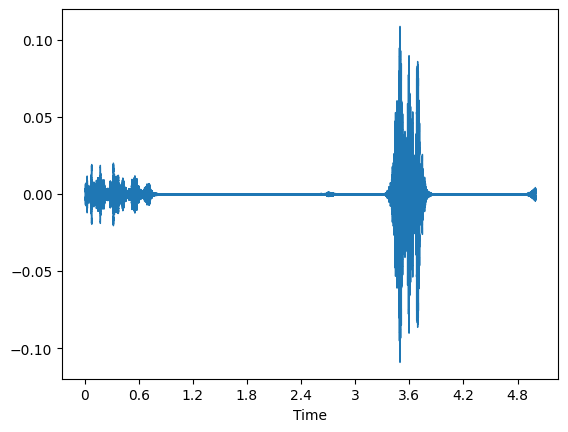

In [6]:
def max_5s(file, sr):
    #open file
    y, sr = librosa.load(file, mono=True, sr=sr)
    y = librosa.util.normalize(y, axis=0)
    # if audio < 5s, append and cut
    # noise1 = y[5*sr:6*sr]
    y = removeNoise(audio_clip=f_high(y, sr), noise_clip=y,
            n_grad_freq=2,
            n_grad_time=4,
            n_fft=2048,
            win_length=2048,
            hop_length=512,
            n_std_thresh=2.5,
            prop_decrease=1.0,
            verbose=False,
            visual=False
        )
    if len(y) < 5*sr:
        for i in range(int(0.5+5*sr/len(y))):
            y = np.append(y,y)
        return y[:5*sr] #nothing more to do
    # y = f_high(y, sr)
    # get max energy point
    rms = librosa.feature.rms(y=y,frame_length=1024, hop_length=512)
    me = np.argmax(rms)*512
    # Check bounds (for audios >= 5s only)
    if me > 2.5*sr:
        if len(y) < me+2.5*sr: # check for upper bound
            y5 = y[int(me-2.5*sr):int(me+2.5*sr)] #2.5 seg before and 2.5 after
        else:
            y5 = y[len(y)-5*sr:len(y)] # get the last 5 s
    else:
        y5 = y[:5*sr] # get the first 5 s
    return y5

y = max_5s(e_file, sr)
librosa.display.waveshow(y,sr=sr, x_axis='time')

In [7]:
df = pd.read_csv('./train_extended.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23784 entries, 0 to 23783
Data columns (total 29 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   rating            23784 non-null  float64
 1   playback_used     21938 non-null  object 
 2   ebird_code        23784 non-null  object 
 3   channels          23784 non-null  object 
 4   date              23784 non-null  object 
 5   duration          23784 non-null  int64  
 6   filename          23784 non-null  object 
 7   species           23784 non-null  object 
 8   title             23784 non-null  object 
 9   secondary_labels  23784 non-null  object 
 10  bird_seen         21827 non-null  object 
 11  sci_name          23784 non-null  object 
 12  location          23784 non-null  object 
 13  latitude          23359 non-null  float64
 14  sampling_rate     23784 non-null  object 
 15  type              23755 non-null  object 
 16  elevation         23784 non-null  object

In [8]:
# Selecting high-rated sound only
dff = df[df['rating'] > 4.0]
# Selecting shorter files only, less data to process
dff = dff[dff['duration'] < 20]
print(len(dff))

921


In [9]:
# Selecting birds with more than 10 examples left
dfc = dff.groupby('ebird_code')['ebird_code'].count()
dff = dff[~dff['ebird_code'].isin(dfc[dfc.values < 50].index)]
print(len(dff))

253


<AxesSubplot: xlabel='ebird_code'>

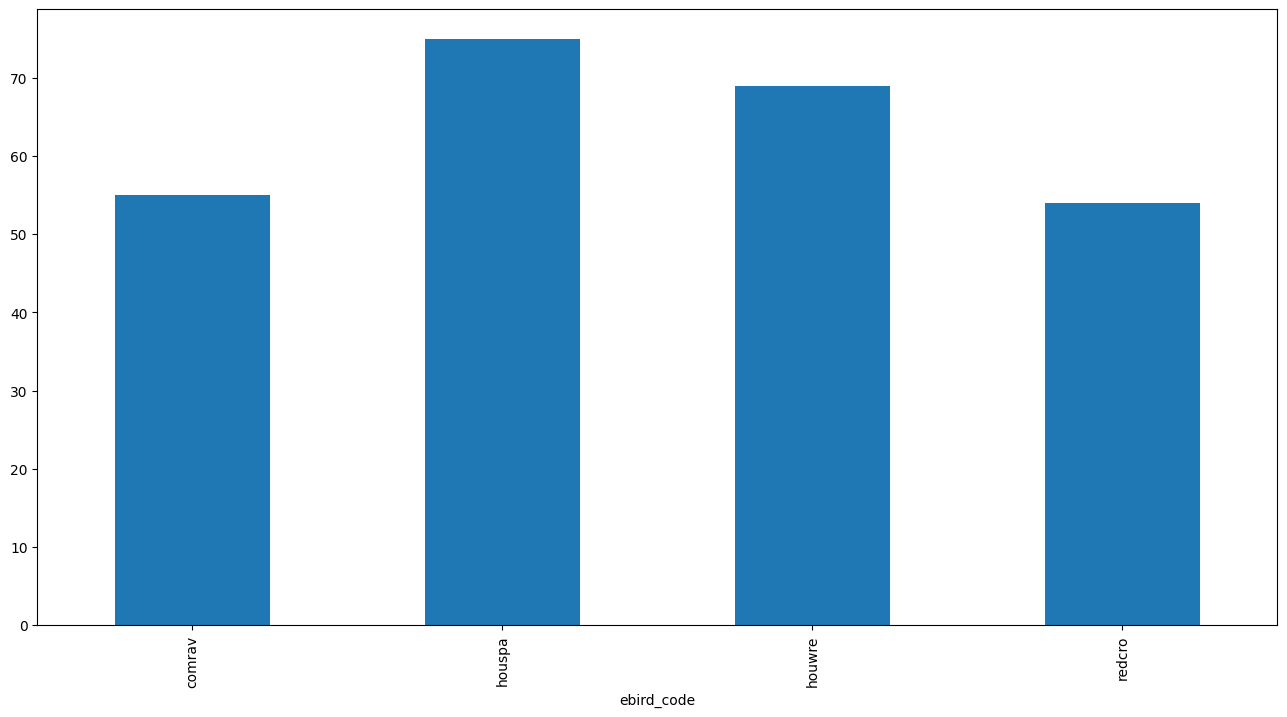

In [10]:
# Not all classes may be represented according to filtering
# Several classes decreased a lot
dfc = dff.groupby('ebird_code')['ebird_code'].count()
plt.figure(figsize=(16,8))
dfc.plot.bar()

In [57]:
features_df = pd.DataFrame([])

In [11]:
audio_path = Path('/media/sasanka/Expansion/xeno-canto-bird-recordings-extended-a-m/A-M')

sound_categories = dff['ebird_code'].unique()

audios = []
Y = []
Y_classes = []
label = 0
for category_name in sound_categories:
    #Walk through the dataframe filename values
    l_files = dff[dff['ebird_code'] == category_name]['filename'].values
    for file_name in l_files:
        try:
            sound_path = audio_path/category_name/file_name
            y = max_5s(sound_path, sr)
            mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=n_mels)
            to_append = ''
            for e in mfcc:
                to_append += f' {np.mean(e)} {np.std(e)}'
            S = np.fromstring(to_append, dtype=float, sep=" ")
            audios.append(S)
            Y.append(label)
            Y_classes.append(category_name)
            features_df()
        except:
            print(sound_path)
            pass
    label +=1
    if label == 20:
        break
X = np.array(audios)
Y = np.array(Y)
num_classes = len(sound_categories)

/media/sasanka/Expansion/xeno-canto-bird-recordings-extended-a-m/A-M/redcro/XC583426.mp3
/media/sasanka/Expansion/xeno-canto-bird-recordings-extended-a-m/A-M/redcro/XC580125.mp3
/media/sasanka/Expansion/xeno-canto-bird-recordings-extended-a-m/A-M/redcro/XC579436.mp3
/media/sasanka/Expansion/xeno-canto-bird-recordings-extended-a-m/A-M/redcro/XC577399.mp3
/media/sasanka/Expansion/xeno-canto-bird-recordings-extended-a-m/A-M/redcro/XC577385.mp3
/media/sasanka/Expansion/xeno-canto-bird-recordings-extended-a-m/A-M/redcro/XC574883.mp3
/media/sasanka/Expansion/xeno-canto-bird-recordings-extended-a-m/A-M/redcro/XC572662.mp3
/media/sasanka/Expansion/xeno-canto-bird-recordings-extended-a-m/A-M/redcro/XC570119.mp3
/media/sasanka/Expansion/xeno-canto-bird-recordings-extended-a-m/A-M/redcro/XC569389.mp3
/media/sasanka/Expansion/xeno-canto-bird-recordings-extended-a-m/A-M/redcro/XC569344.mp3
/media/sasanka/Expansion/xeno-canto-bird-recordings-extended-a-m/A-M/redcro/XC569334.mp3
/media/sasanka/Expans

In [52]:
perc_test = 0.2

x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=perc_test, stratify=Y, random_state=2)
print(x_train.shape)
print(x_test.shape)

(159, 128)
(40, 128)


In [55]:
from sklearn.neighbors import KNeighborsClassifier
clf = KNeighborsClassifier(n_neighbors=7)
clf.fit(x_train, y_train)

KNeighborsClassifier(n_neighbors=7)

In [56]:
y_pred = clf.predict(x_test)
print("Total samples: "+ str(len(x_test)))

print('Test accuracy:', len(y_pred[y_pred==y_test])/len(y_pred))

print('Confusion Matrix')
print(confusion_matrix(y_test, y_pred))
print('Classification Report')
print(classification_report(y_test, y_pred, target_names=np.unique(Y_classes)))

Total samples: 40
Test accuracy: 0.625
Confusion Matrix
[[ 8  3  0]
 [ 2 11  2]
 [ 3  5  6]]
Classification Report
              precision    recall  f1-score   support

      comrav       0.62      0.73      0.67        11
      houspa       0.58      0.73      0.65        15
      houwre       0.75      0.43      0.55        14

    accuracy                           0.62        40
   macro avg       0.65      0.63      0.62        40
weighted avg       0.65      0.62      0.62        40



In [38]:
import pickle

In [43]:
pickle.dump(clf, open('./models/comrav-houspa-houwre-knn.pkl', 'wb'))

In [17]:
y_train_pred = clf.predict(x_train)
print("Total samples: "+ str(len(x_train)))

print('Train accuracy:', len(y_train_pred[y_train_pred==y_train])/len(y_train_pred))

Total samples: 159
Train accuracy: 0.6981132075471698


In [18]:
from sklearn.linear_model import SGDClassifier
clf = SGDClassifier()
clf.fit(x_train, y_train)

SGDClassifier()

In [19]:
y_pred = clf.predict(x_test)
print("Total samples: "+ str(len(x_test)))

print('Test accuracy:', len(y_pred[y_pred==y_test])/len(y_pred))

print('Confusion Matrix')
print(confusion_matrix(y_test, y_pred))
print('Classification Report')
print(classification_report(y_test, y_pred, target_names=np.unique(Y_classes)))

Total samples: 40
Test accuracy: 0.525
Confusion Matrix
[[10  0  1]
 [ 8  4  3]
 [ 4  3  7]]
Classification Report
              precision    recall  f1-score   support

      comrav       0.45      0.91      0.61        11
      houspa       0.57      0.27      0.36        15
      houwre       0.64      0.50      0.56        14

    accuracy                           0.53        40
   macro avg       0.55      0.56      0.51        40
weighted avg       0.56      0.53      0.50        40

